<a href="https://colab.research.google.com/github/pooja-joshi-bits/EPFforAll/blob/main/PJM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# PJM


In [ ]:

# Importing library

# Below five lines for generalization
import numpy as np          #To perform mathematical operations 
# from numpy.random import seed
# seed(42)
# from tensorflow import set_random_seed
# set_random_seed(42)

import time
# import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, r2_score
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor


from sklearn.decomposition import PCA
#To show the output within the jupyter notebook itself!
%matplotlib inline 



from timeit import default_timer as timer
from datetime import timedelta

from keras import layers
from keras import models
from keras.layers import Activation, LeakyReLU, PReLU, ELU, ReLU
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History
from keras import losses
from keras import regularizers


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation


import io
import os   #
import requests

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

# import dill
# dill.dump_session('notebook_env.db')

In [ ]:
start = timer()
# do stuff

df = pd.read_csv("NordPool.csv")  #Import the NORD POOL Dataset 
df

,Date,Price,Grid load forecast,Wind power forecast
0,1/1/2013 0:00,31.05,42497.0,2798.0
1,1/1/2013 1:00,30.47,41463.0,2417.0
2,1/1/2013 2:00,28.92,40812.0,2036.0
3,1/1/2013 3:00,27.88,40246.0,1706.0
4,1/1/2013 4:00,26.96,40088.0,1427.0
...,...,...,...,...
52411,12/24/2018 19:00,50.72,52591.0,2544.0
52412,12/24/2018 20:00,49.86,51787.0,2785.0
52413,12/24/2018 21:00,49.09,51488.0,2919.0
52414,12/24/2018 22:00,49.02,50928.0,3119.0


In [ ]:
# Input data i.e. xd (float values) # channel gains

df = pd.read_csv("PJMNP.csv")  #Import the PJM Dataset 
df["Date"] = pd.to_datetime(df["Date"]) 
df["Date"].max() - df["Date"].min()
df["Date_"] = df["Date"].dt.date
df["Hour_"] = df["Date"].dt.hour
reshaped = df.pivot(index='Date_', columns='Hour_', values=[' Price', ' Grid load forecast', ' Wind power forecast'])
#reshaped = df.pivot(index='Date_', columns='Hour_', values=[' Zonal COMED price', ' System load forecast', ' Zonal COMED load foecast'])

reshaped.columns = [f"{col[0]}_{str(col[1])}" for col in reshaped.columns]
reshaped.reset_index(drop = False, inplace = True)
df = reshaped
df

,Date_,Price_0,Price_1,Price_2,Price_3,Price_4,Price_5,Price_6,Price_7,Price_8,...,Wind power forecast_14,Wind power forecast_15,Wind power forecast_16,Wind power forecast_17,Wind power forecast_18,Wind power forecast_19,Wind power forecast_20,Wind power forecast_21,Wind power forecast_22,Wind power forecast_23
0,2013-01-01,25.464211,23.554578,22.122277,21.592066,21.546501,21.962992,23.986774,24.609571,26.730549,...,11532.0,11521.0,11671.0,12533.0,13474.0,13723.0,13681.0,13487.0,13132.0,12462.0
1,2013-01-02,26.698947,26.025287,25.699280,25.556450,25.542177,26.900783,31.254310,39.243666,39.269649,...,12813.0,12667.0,12705.0,13454.0,14179.0,14101.0,13936.0,13687.0,13151.0,12255.0
2,2013-01-03,26.001234,24.875769,24.336918,24.389793,24.583507,25.718807,30.890550,37.146193,34.056527,...,12973.0,12917.0,12928.0,13552.0,14271.0,14254.0,14020.0,13723.0,13221.0,12403.0
3,2013-01-04,24.948989,23.283890,22.823623,22.492204,23.148631,23.954595,29.208177,32.667029,33.150181,...,12463.0,12321.0,12292.0,12893.0,13523.0,13578.0,13356.0,13093.0,12694.0,11981.0
4,2013-01-05,25.889003,23.953225,23.011797,22.312382,22.260985,23.452086,24.854757,26.612791,27.797249,...,10878.0,10756.0,10796.0,11393.0,12039.0,12167.0,12071.0,11932.0,11616.0,11066.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2179,2018-12-20,16.945702,16.223748,15.250617,15.830315,15.857879,13.964256,19.171926,29.557410,32.603558,...,11772.0,11704.0,11775.0,12399.0,12751.0,12559.0,12307.0,11994.0,11507.0,10779.0
2180,2018-12-21,21.112615,20.393966,20.184774,20.090547,20.451591,20.930727,23.974641,30.521984,30.424874,...,11768.0,11715.0,11772.0,12405.0,12791.0,12623.0,12338.0,12016.0,11645.0,11017.0
2181,2018-12-22,22.995887,22.597993,22.174348,22.217245,22.433137,22.847845,23.502665,26.626899,28.983212,...,10688.0,10617.0,10720.0,11387.0,11872.0,11826.0,11640.0,11416.0,11118.0,10623.0
2182,2018-12-23,23.731430,23.103720,21.819731,21.954816,22.029745,22.048850,23.290841,25.325224,28.130064,...,10249.0,10252.0,10428.0,11175.0,11724.0,11711.0,11637.0,11433.0,11108.0,10581.0


In [ ]:
reshaped.columns     #To import the library to handle the date

from datetime import datetime, timedelta     
d = reshaped.Date_[0] - timedelta(days=2)
d

datetime.date(2012, 12, 30)

In [ ]:
#We are arranging the DATA as demonstrated by Lago et al. 
"p_{-1}, p_{-2}, p_{-3}, p{-7}, x(1)_{0}, x(2)_{0}, x(1)_{-1}, x(2)_{-1}, x(1)_{-7}, x(2)_{-7}, z"
price_cols = [col for col in reshaped.columns if col.startswith(" Price")]
wind_cols = [col for col in reshaped.columns if col.startswith(" Wind")]
grid_cols = [col for col in reshaped.columns if col.startswith(" Grid")]

def extract_features(dt):
  p_minus0 = reshaped[reshaped.Date_ == dt][price_cols]
  p_minus1 = reshaped[reshaped.Date_ == (dt - timedelta(days=1))][price_cols].iloc[0,:]
  p_minus2 = reshaped[reshaped.Date_ == (dt - timedelta(days=2))][price_cols].iloc[0,:]
  p_minus3 = reshaped[reshaped.Date_ == (dt - timedelta(days=3))][price_cols].iloc[0,:]
  p_minus7 = reshaped[reshaped.Date_ == (dt - timedelta(days=7))][price_cols].iloc[0,:]

  w_minus0 = reshaped[reshaped.Date_ == dt][wind_cols].iloc[0,:]
  w_minus1 = reshaped[reshaped.Date_ == (dt - timedelta(days=1))][wind_cols].iloc[0,:]
  w_minus2 = reshaped[reshaped.Date_ == (dt - timedelta(days=2))][wind_cols].iloc[0,:]
  w_minus3 = reshaped[reshaped.Date_ == (dt - timedelta(days=3))][wind_cols].iloc[0,:]
  w_minus7 = reshaped[reshaped.Date_ == (dt - timedelta(days=7))][wind_cols].iloc[0,:]
  
  
  g_minus0 = reshaped[reshaped.Date_ == dt][grid_cols].iloc[0,:]
  g_minus1 = reshaped[reshaped.Date_ == (dt - timedelta(days=1))][grid_cols].iloc[0,:]
  g_minus2 = reshaped[reshaped.Date_ == (dt - timedelta(days=2))][grid_cols].iloc[0,:]
  g_minus3 = reshaped[reshaped.Date_ == (dt - timedelta(days=3))][grid_cols].iloc[0,:]
  g_minus7 = reshaped[reshaped.Date_ == (dt - timedelta(days=7))][grid_cols].iloc[0,:]
  
  features = np.array((p_minus1, p_minus2, p_minus3, p_minus7, w_minus0, w_minus1, w_minus7, g_minus0, g_minus1, g_minus7)).ravel()
  features = np.expand_dims(features, axis = 0)
  target = np.array(p_minus0)
  return features, target

In [ ]:
grid_cols

[' Grid load forecast_0',
 ' Grid load forecast_1',
 ' Grid load forecast_2',
 ' Grid load forecast_3',
 ' Grid load forecast_4',
 ' Grid load forecast_5',
 ' Grid load forecast_6',
 ' Grid load forecast_7',
 ' Grid load forecast_8',
 ' Grid load forecast_9',
 ' Grid load forecast_10',
 ' Grid load forecast_11',
 ' Grid load forecast_12',
 ' Grid load forecast_13',
 ' Grid load forecast_14',
 ' Grid load forecast_15',
 ' Grid load forecast_16',
 ' Grid load forecast_17',
 ' Grid load forecast_18',
 ' Grid load forecast_19',
 ' Grid load forecast_20',
 ' Grid load forecast_21',
 ' Grid load forecast_22',
 ' Grid load forecast_23']

In [ ]:
from tqdm import tqdm     #To extract the features of the data
features_array = None     #To initialize
target_Array = None
for dt in tqdm(reshaped.Date_.sort_values()[7:], total = len(reshaped.Date_.sort_values()[7:])):  #starting from 7th day
  e, t = extract_features(dt)
  if features_array is None:
    features_array = e
    target_array = t
  else:
    features_array = np.append(features_array, e, axis = 0)
    target_array = np.append(target_array, t, axis = 0)



100%|██████████| 2177/2177 [00:54<00:00, 39.58it/s]


In [ ]:
date_list = reshaped.Date_.sort_values()[7:]
# date_list.iloc[0] #We do not consider first 1 to 7 days

start_date_training = pd.to_datetime("2013-01-08").date()
end_date_training = pd.to_datetime("2016-03-07").date()

start_date_validation = pd.to_datetime("2016-03-08").date()
end_date_validation = pd.to_datetime("2016-12-26").date()

start_date_test = pd.to_datetime("2016-12-27").date()
end_date_test = pd.to_datetime("2018-12-24").date()

for i, value in enumerate(date_list):    #loop to compute the index of start date [Training]
  if value == start_date_training:
    print(i)
    break

for j, value in enumerate(date_list):    #loop to compute the index of end date [Training]
  if value == end_date_training:
    print(j)
    break

for k, value in enumerate(date_list):    #loop to compute the index of start date [Validation]
  if value == start_date_validation:
    print(k)
    break

for l, value in enumerate(date_list):    #loop to compute the index of end date [Validation]
  if value == end_date_validation:
    print(l)
    break

for m, value in enumerate(date_list):    #loop to compute the index of start date [Test]
  if value == start_date_test:
    print(m)
    break

for n, value in enumerate(date_list):    #loop to compute the index of end date [Test]
  if value == end_date_test:
    print(n)
    break

0
1154
1155
1448
1449
2176


In [ ]:
target_array.shape

(2177, 24)

In [ ]:
# From here we are doing the preprocessing of our dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler 

#scaler1 = MinMaxScaler()
scaler2 = StandardScaler()
#scaler3 = RobustScaler()



features_array_scaled = scaler2.fit_transform(features_array)  # normalizing the features
target_array_scaled = target_array  # normalizing the features

features_array_scaled.shape

(2177, 240)

In [ ]:
features_array.shape

(2177, 240)

# New Section

In [ ]:
#Rearranging the matrices in training - test - validation
X_train = features_array_scaled[0:1154]
y_train = target_array_scaled[0:1154]
X_validation = features_array_scaled[1155:1448]
y_validation = target_array_scaled[1155:1448]
X_test = features_array_scaled[1449:2176]
y_test = target_array_scaled[1449:2176]

In [ ]:
#Rearranging the matrices (T2) training - test - validation (70% - 15% - 15%)
#X_train = features_array_scaled[0:1523]
#y_train = target_array_scaled[0:1523]
#X_validation = features_array_scaled[1524:1850]
#y_validation = target_array_scaled[1524:1850]
#X_test = features_array_scaled[1850:2176]
#y_test = target_array_scaled[1850:2176]

In [ ]:
#Rearranging the matrices (T2) training - test - validation (75% - 15% - 10%)
#X_train = features_array_scaled[0:1632]
#y_train = target_array_scaled[0:1632]
#X_validation = features_array_scaled[1633:1960]
#y_validation = target_array_scaled[1633:1960]
#X_test = features_array_scaled[1961:2176]
#y_test = target_array_scaled[1961:2176]

In [ ]:
#T3 (82% - 08% - 10%)
#X_train = features_array_scaled[0:1800]
#y_train = target_array_scaled[0:1800]
#X_validation = features_array_scaled[1801:2000]
#y_validation = target_array_scaled[1801:2000]
#X_test = features_array_scaled[2001:2176]
#y_test = target_array_scaled[2001:2176]

In [ ]:
y_test.shape

(727, 24)

In [ ]:
# Building neural network
model = Sequential()
model.add(Dense(240, input_dim=X_train.shape[1], kernel_initializer='glorot_normal', activation = 'linear')) # Input layer and 1st hidden layer
model.add(Dropout(0.01, input_shape=(240,)))
model.add(Dense(10, kernel_initializer='glorot_normal', activation = 'relu')) # 1st Hidden layer
model.add(Dropout(0.01, input_shape=(240,)))
model.add(Dense(10, kernel_initializer='glorot_normal', activation = 'relu')) # 2nd Hidden layer
#model.add(ReLU(alpha=0.01)) # Relu for the hidden layer
model.add(Dense(24, kernel_initializer='glorot_normal', activation = 'linear')) # output 

In [ ]:
# Compiling Neural network
from tensorflow.keras.callbacks import EarlyStopping
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mean_squared_error']) 
monitor = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='auto', restore_best_weights=True)

In [ ]:
#model_history=model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=512, verbose=2, callbacks=[monitor], epochs=1000)
#model_history=model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=512, verbose=2, epochs=1000)
#model_history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation), verbose=2, callbacks=[monitor], epochs=100, shuffle = True)
model_history=model.fit(X_train, y_train, validation_data=(X_validation, y_validation), verbose=2, epochs=1500, shuffle = False)

Epoch 1/1500
37/37 - 2s - loss: 1666.5565 - mean_squared_error: 1666.5565 - val_loss: 812.5290 - val_mean_squared_error: 812.5290 - 2s/epoch - 42ms/step
Epoch 2/1500
37/37 - 0s - loss: 1546.3002 - mean_squared_error: 1546.3002 - val_loss: 706.9917 - val_mean_squared_error: 706.9917 - 156ms/epoch - 4ms/step
Epoch 3/1500
37/37 - 0s - loss: 1315.0487 - mean_squared_error: 1315.0487 - val_loss: 517.1528 - val_mean_squared_error: 517.1528 - 174ms/epoch - 5ms/step
Epoch 4/1500
37/37 - 0s - loss: 1013.2631 - mean_squared_error: 1013.2631 - val_loss: 386.8483 - val_mean_squared_error: 386.8483 - 153ms/epoch - 4ms/step
Epoch 5/1500
37/37 - 0s - loss: 781.5259 - mean_squared_error: 781.5259 - val_loss: 330.3769 - val_mean_squared_error: 330.3769 - 149ms/epoch - 4ms/step
Epoch 6/1500
37/37 - 0s - loss: 648.5183 - mean_squared_error: 648.5183 - val_loss: 277.6649 - val_mean_squared_error: 277.6649 - 168ms/epoch - 5ms/step
Epoch 7/1500
37/37 - 0s - loss: 565.9224 - mean_squared_error: 565.9224 - va

In [ ]:
# To evaluate model validation loss
validation_loss = model.evaluate(X_validation, y_validation)
validation_loss

10/10 [==============================] - 0s 3ms/step - loss: 37.5095 - mean_squared_error: 37.5095


[37.50954055786133, 37.50954055786133]

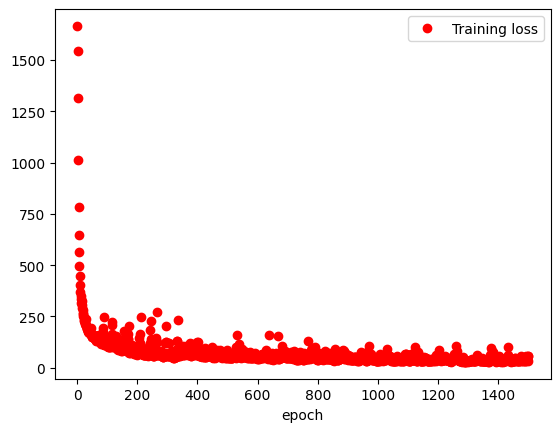

In [ ]:
# To plot training loss only
loss = model_history.history['loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


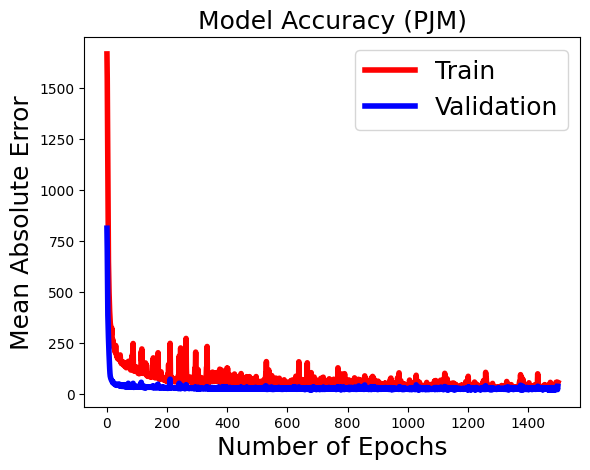

In [ ]:
# list all data in history
print(model_history.history.keys())
%matplotlib inline
# summarize history for accuracy
acc = model_history.history['mean_squared_error']
val_acc = model_history.history['val_mean_squared_error']
hfont = {'fontname':'Arial'}
plt.plot(acc, color='red',linewidth=4)
plt.plot(val_acc, color='blue',linewidth=4)
plt.title('Model Accuracy (PJM)', fontsize=18, **hfont)
plt.ylabel('Mean Absolute Error', fontsize=18, **hfont)
plt.xlabel('Number of Epochs', fontsize=18, **hfont)
plt.legend(['Train', 'Validation'], loc='upper right', prop={"size":18})
plt.savefig('modelAccuracyPJM.pdf')
plt.show()

In [ ]:
y_pred = model.predict(X_test)   

23/23 [==============================] - 0s 2ms/step


In [ ]:
y_pred.shape

(727, 24)

In [ ]:
#inverse transform
#from sklearn import preprocessing
#y_pred = StandardScaler().inverse_transform(y_pred)


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error


#rMAE_test(y_test, y_pred):
 #   numerator = np.sum(np.abs(y_pred - y_test))
  #  denominator = np.sum(np.abs(np.mean(y_test) - y_test))
   # return numerator / denominator

rMAE= (np.sum(np.abs(y_pred - y_test)))/(np.sum(np.abs(np.mean(y_test) - y_test)))
print("Test relative Mean absolute error (rMAE): {}".format(rMAE))


# Evaluating the model # Test error
# Measure MAE error
mae_test = metrics.mean_absolute_error(y_test, y_pred)
print("Test Mean absolute error (MAE): {}".format(mae_test))

# Measure MSE error  
#mse_test = metrics.mean_squared_error(y_test, y_pred)
#print("Test Mean Squared error (MSE): {}".format(mse_test))

# Measure MAPE error
mape_test = np.mean(np.abs((y_test - y_pred)/y_test))*100
#mape_test = metrics.mean_absolute_percentage_error(y_test, y_pred)
print("Test Mean percentage absolute error (MAPE): {}".format(mape_test))

# Measure sMAPE
sMAPE = 1/len(y_pred)*(np.sum(2 * np.abs(y_pred-y_test)/(np.abs(y_test) + np.abs(y_pred))))
#sMAPE = 1/len(y_test)*np.sum(2 * np.abs(y_pred-y_test)/(np.abs(y_test) + np.abs(y_pred)))
print("Test symmetric mean absolute percentage error (sMAPE): {}".format(sMAPE))


 #   def smape(A, F):
    #return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))


# Measure RMSE error 
rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print("Test Root mean squared error (RMSE): {}".format(rmse_test))

Test relative Mean absolute error (rMAE): 0.552174562428704
Test Mean absolute error (MAE): 4.387151235881289
Test Mean percentage absolute error (MAPE): 37.98143847880986
Test symmetric mean absolute percentage error (sMAPE): 3.8638942267448515
Test Root mean squared error (RMSE): 7.912403033796303


In [ ]:
# Regression score for training

r2_score_train = metrics.r2_score(y_test, y_pred)
print("R2 Score Train: {}".format(r2_score_train))

R2 Score Train: 0.23486771784665908


In [ ]:
y_pred.shape

(727, 24)

In [ ]:
y_test.shape

(727, 24)

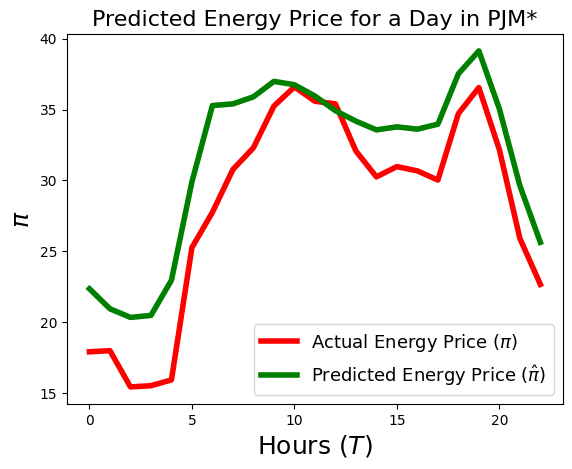

In [ ]:
test = y_test[100,1:]
#test =np.roll(test, -1) #rotate left
pred = y_pred[100,1:]
plt.plot(test, color='red',linewidth=4)
plt.plot(pred, color='green',linewidth=4)
plt.title('Predicted Energy Price for a Day in PJM*', fontsize=16, **hfont)
plt.ylabel('$\pi$', fontsize=18, **hfont)
plt.xlabel('Hours ($T$)', fontsize=18, **hfont)
plt.legend(['Actual Energy Price ($\pi$)', 'Predicted Energy Price ($\hat{\pi}$)'], loc='best', prop={"size":13})
plt.savefig('Prediction Curve for a day in PJM.pdf')

In [ ]:
y_test.shape

(727, 24)

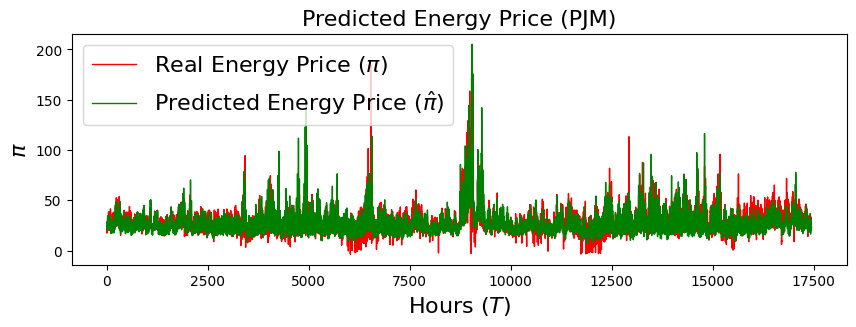

In [ ]:
y_test_reshape = y_test.reshape(-1)
y_pred_reshape = y_pred.reshape(-1)

plt.figure(figsize=(10,3))
plt.plot(y_test_reshape, color='red',linewidth=1)
plt.plot(y_pred_reshape, color='green',linewidth=1)
plt.title('Predicted Energy Price (PJM)', fontsize=16, **hfont)
plt.ylabel('$\pi$', fontsize=16, **hfont)
plt.xlabel('Hours ($T$)', fontsize=16, **hfont)
plt.legend(['Real Energy Price ($\pi$)', 'Predicted Energy Price ($\hat{\pi}$)'], loc='best', prop={"size":16})
plt.savefig('Prediction Curve PJM for T1.pdf')

In [ ]:
df1 = pd.DataFrame(y_pred)

df1.to_csv('pred_data_NP.csv')

In [ ]:
df2 = pd.DataFrame(y_test)

df2.to_csv('test_data.csv')

In [ ]:
end = timer()
print(timedelta(seconds=end-start))

0:05:35.400675


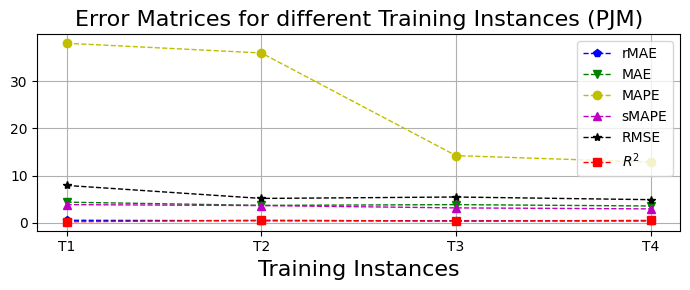

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(7,3))
hfont = {'fontname':'Arial'}
#plt.plot(EpisodeIndex, color='red',linewidth=3)

rMAE  = [0.55, 0.45, 0.44, 0.42]
MAE  = [4.38, 3.70, 3.86, 3.57]
MAPE = [37.98, 35.93, 14.22, 12.85]
sMAPE = [3.86, 3.66, 3.17, 2.96]
RMSE = [7.92, 5.17, 5.47, 4.91]
R2 = [0.23, 0.56, 0.39, 0.52]



plt.plot(rMAE,'p--', color='blue', linewidth=1)
plt.plot(MAE,'v--', color='green',linewidth=1)
plt.plot(MAPE,'o--', color='y',linewidth=1)
plt.plot(sMAPE,'^--', color='m',linewidth=1)
plt.plot(RMSE,'*--', color='k',linewidth=1)
plt.plot(R2,'s--', color='r',linewidth=1)
#plt.ylim(ymin = -15500)
#plt.ylim(ymax = 1000)
#plt.plot(AvgEpisodeReward_lr_3,'-.', color='blue',linewidth=2)
plt.title('Error Matrices for different Training Instances (PJM)', fontsize=16, **hfont)
#plt.ylabel('Average Reward $(\mathrm{r})$', fontsize=16, **hfont)
x1 = [0,1,2,3]
squad = ['T1','T2','T3','T4']
plt.xticks(x1, squad)
#plt.xticks(squad, minor=False, rotation=45)


plt.xlabel('Training Instances', fontsize=16, **hfont)
plt.legend(['rMAE', 'MAE', 'MAPE', 'sMAPE', 'RMSE', '$R^2$' ], loc='upper right', prop={"size":10})
plt.grid()
plt.tight_layout()
plt.savefig('variablesPJM.pdf')
plt.show()
